# Задача 5. Обучение без учителя

**Автор**: Степырев Даниил

**Группа:** 22.М05

## Задача

- [✔] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [✔] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [✔] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [✔] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [✔] При обучении использовать **подбор гиперпараметров**.
- [✔] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [✔] (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [✔] (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

## Подключение библиотек

Подключаем используемые библиотеки:

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

## Датасет

Будем использовать датасет данных о продаже домов. Целевой признак -- цена продажи. В датасете **81 столбец**. Датасет взят с сайте Kaggle: https://www.kaggle.com/datasets/animeshparikshya/house-sale-data-81-column?resource=download.

Считаем данные:

In [2]:
df = pd.read_csv('Dataset/house_selling.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Разведочный анализ (EDA)

Общее число пропущенных значений:

In [3]:
df.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

Видим, что в датасете есть пропущенные значения. Посчитаем, сколько всего строк в датасете:

In [4]:
len(df.index)

1460

Видим, что в некоторых столбцы пропущены значения в большинстве строк. Например, только в трёх строках в столбце **PoolQC** есть значения. От подобных признаков можно будет избавиться.

Посмотрим значения целевого признака:

In [5]:
df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Преобразуем количественный признак цены в категориальный. Разделим диапазон на 10 значений:

In [6]:
df['SalePrice_category'] = pd.qcut(df['SalePrice'], 10)
df['SalePrice_category'].sort_values().unique()

[(34899.999, 106475.0], (106475.0, 124000.0], (124000.0, 135500.0], (135500.0, 147000.0], (147000.0, 163000.0], (163000.0, 179280.0], (179280.0, 198620.0], (198620.0, 230000.0], (230000.0, 278000.0], (278000.0, 755000.0]]
Categories (10, interval[float64, right]): [(34899.999, 106475.0] < (106475.0, 124000.0] < (124000.0, 135500.0] < (135500.0, 147000.0] ... (179280.0, 198620.0] < (198620.0, 230000.0] < (230000.0, 278000.0] < (278000.0, 755000.0]]

In [7]:
df["SalePrice_category"] = 0
df.loc[df['SalePrice'] <= 106475.0, 'SalePrice_category'] = 0
df.loc[(df['SalePrice'] > 106475.0) & (df['SalePrice'] <= 124000.0), 'SalePrice_category'] = 1
df.loc[(df['SalePrice'] > 124000.0) & (df['SalePrice'] <= 135500.0), 'SalePrice_category'] = 2
df.loc[(df['SalePrice'] > 135500.0) & (df['SalePrice'] <= 147000.0), 'SalePrice_category'] = 3
df.loc[(df['SalePrice'] > 147000.0) & (df['SalePrice'] <= 163000.0), 'SalePrice_category'] = 4
df.loc[(df['SalePrice'] > 163000.0) & (df['SalePrice'] <= 179280.0), 'SalePrice_category'] = 5
df.loc[(df['SalePrice'] > 179280.0) & (df['SalePrice'] <= 198620.0), 'SalePrice_category'] = 6
df.loc[(df['SalePrice'] > 198620.0) & (df['SalePrice'] <= 230000.0), 'SalePrice_category'] = 7
df.loc[(df['SalePrice'] > 230000.0) & (df['SalePrice'] <= 278000.0), 'SalePrice_category'] = 8
df.loc[(df['SalePrice'] > 278000.0), 'SalePrice_category'] = 9

df["SalePrice_category"].value_counts().sort_index()

0    146
1    149
2    144
3    150
4    143
5    144
6    146
7    149
8    144
9    145
Name: SalePrice_category, dtype: int64

Видим, что число строк для каждого класса цены примерно одинаковое. Удалим исходный параметр цены.

In [8]:
df.drop(["SalePrice"], axis=1, inplace=True)
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice_category
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,7
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,6
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,7
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,3
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,5
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,7
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,8
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,3


## Преобразование признаков

Преобразуем все строчные признаки в числовые:

In [9]:
# Находим все числовые признаки
string_columns = list(df.select_dtypes(include=[object]).columns)
for col in string_columns:
    # Находим все уникальные значения признака.
    str_elements = df[col].unique()
    
    # Создаём числовой массив-замену.
    int_elements = np.arange(str_elements.size)
    
    # Преобразовываем признак.
    df[col].replace(str_elements, int_elements, inplace = True)

Заполним все незаполненные значения нулями:

In [10]:
# Находим столбцы с пустыми с незаполненными значениями нулями.
columns_with_nan = df.columns[df.isna().any()].tolist()

# Заполним все пустые значения нулями.
for col in columns_with_nan:
    df[col] = df[col].fillna(0)
    
df.columns[df.isna().any()].tolist()

[]

## Визуализация данных с помощью PCA и t-SNE

Подготовим данные:

In [11]:
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=["SalePrice_category"])
y = df["SalePrice_category"]

scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.000000,0.235294,0.0,0.207668,0.033420,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,0.0,0.0
1,0.000685,0.000000,0.0,0.255591,0.038795,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,0.0,0.0
2,0.001371,0.235294,0.0,0.217252,0.046507,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,0.50,0.0,0.0
3,0.002056,0.294118,0.0,0.191693,0.038561,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,0.0,0.2
4,0.002742,0.235294,0.0,0.268371,0.060576,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.50,0.0,0.0


Подготовим функцию визуализации данных:

In [12]:
def visualize_data(dataframe, title = ""):
    plt.figure(figsize=(15, 15))
    plt.scatter(
        dataframe[:, 0],
        dataframe[:, 1],
        c=y,
        cmap=plt.colormaps["nipy_spectral"].resampled(10),
        edgecolors="none",
        alpha=0.4)
    plt.colorbar()
    plt.title(f"Визуализация {title}")
    plt.grid(None)

Снизим размерность до 2 с помощью алгоритма **PCA**:

In [13]:
%%time
from sklearn.decomposition import PCA

pca = PCA()
pca_2 = pca.fit_transform(X)

CPU times: total: 78.1 ms
Wall time: 57.6 ms


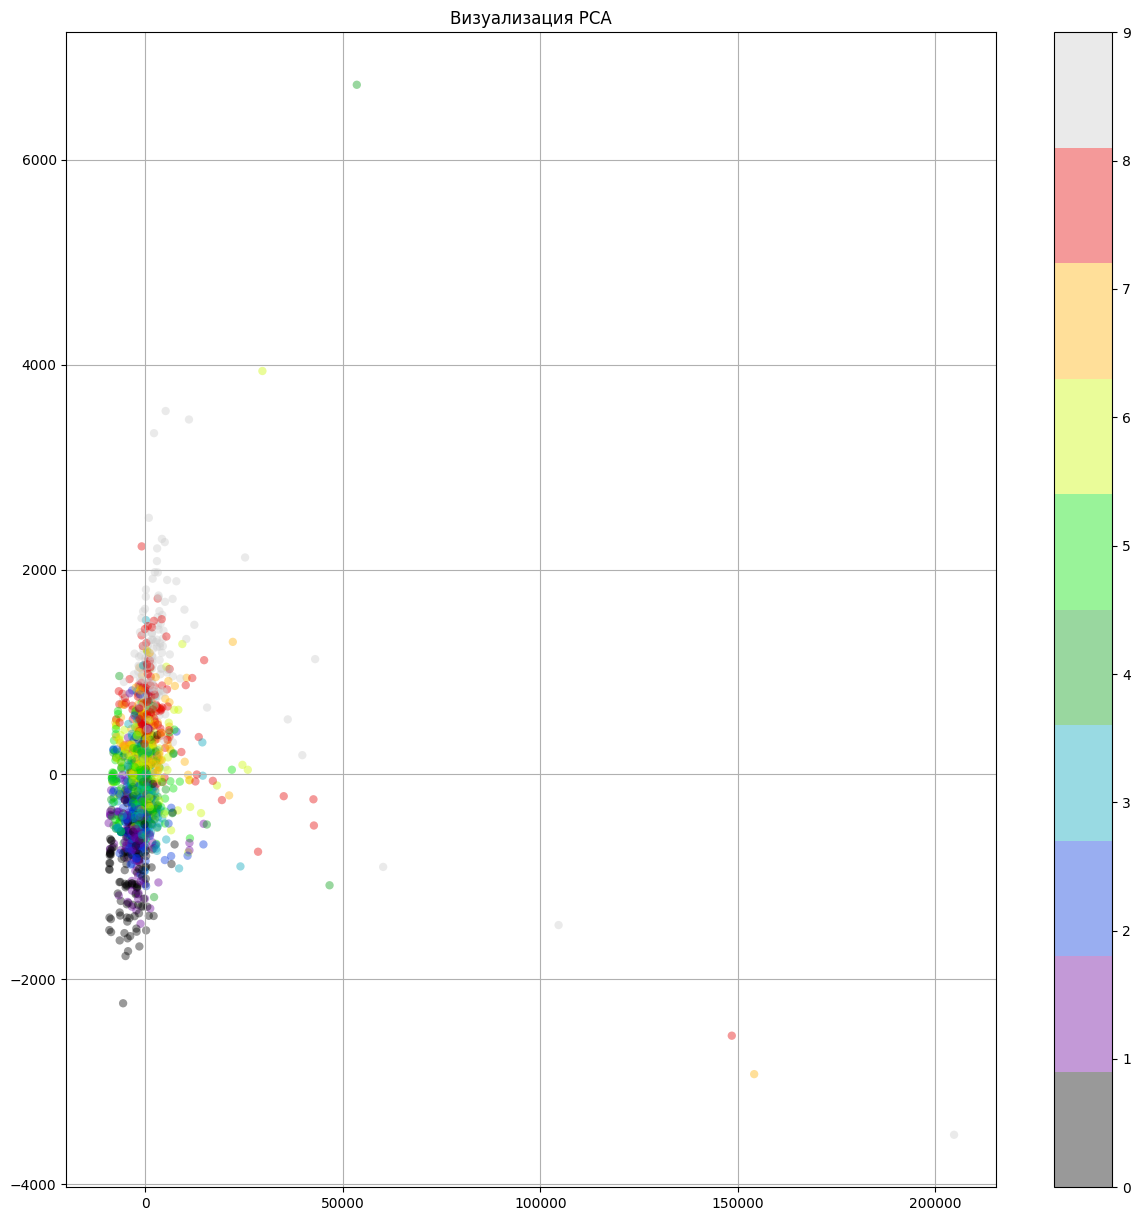

In [14]:
visualize_data(pca_2, "PCA")

Снизим размерность до 2 с помощью алгоритма **t-SNE**:

In [15]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
tsne_2 = tsne.fit_transform(X)

CPU times: total: 40.5 s
Wall time: 2.59 s


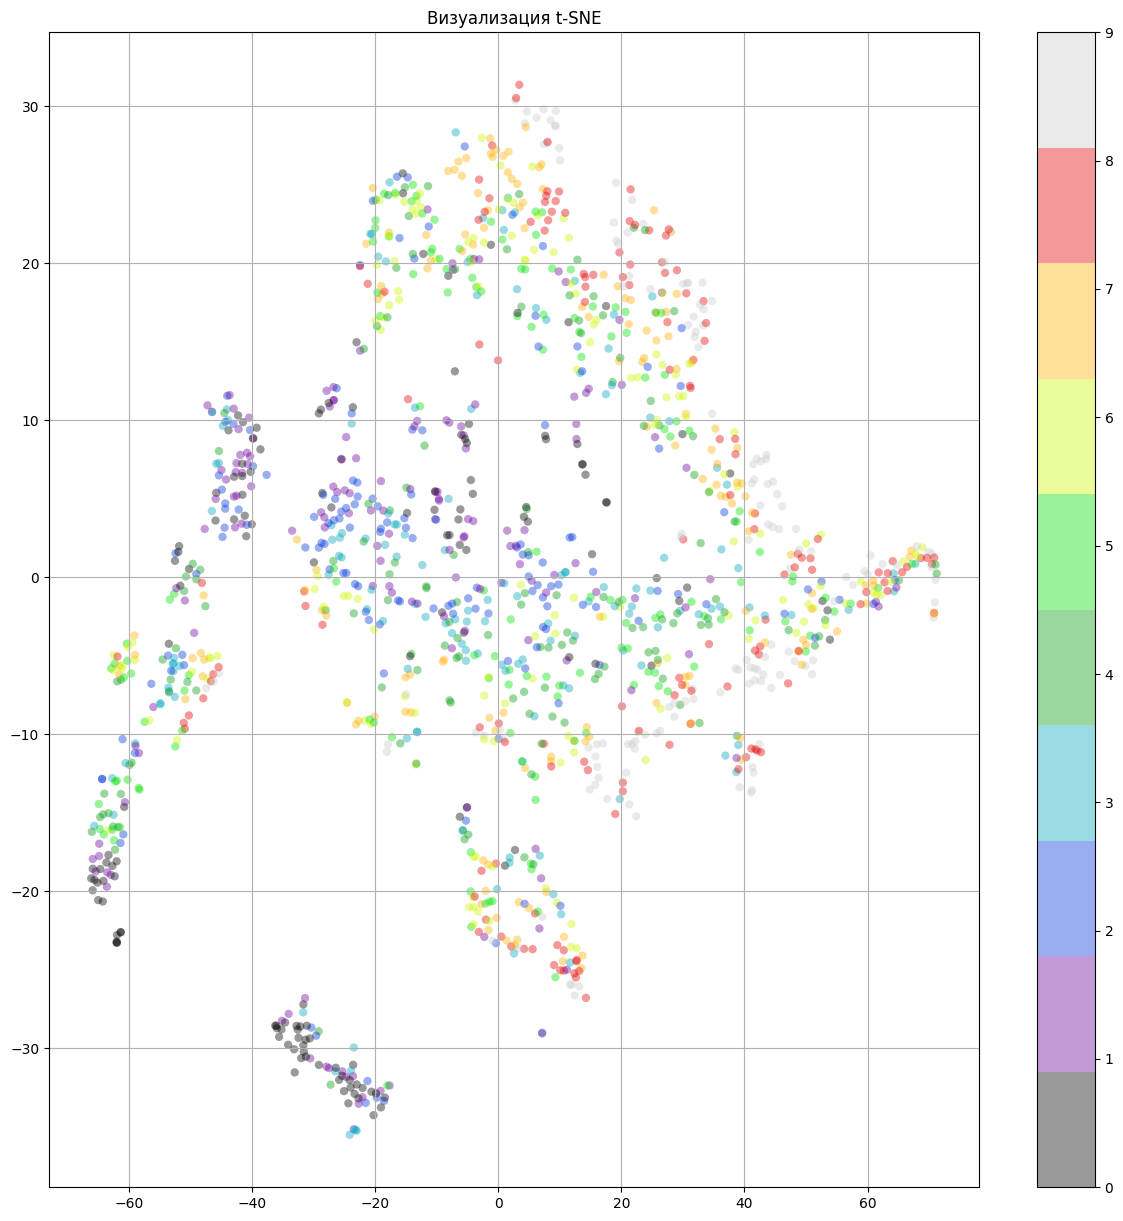

In [16]:
visualize_data(tsne_2, "t-SNE")

Видим, что алгоритм **t-SNE** работал заметно дольше, чем **PCA**. Однако алгоритм **t-SNE** лучше отработал: кластеры образуют явные группы, хотя местами и перемешиваются.

Проведём аналогичные эксперименты, снизив размерность до **3**:

In [17]:
%%time

pca = PCA(n_components=3)
pca_3 = pca.fit_transform(X)

CPU times: total: 0 ns
Wall time: 8 ms


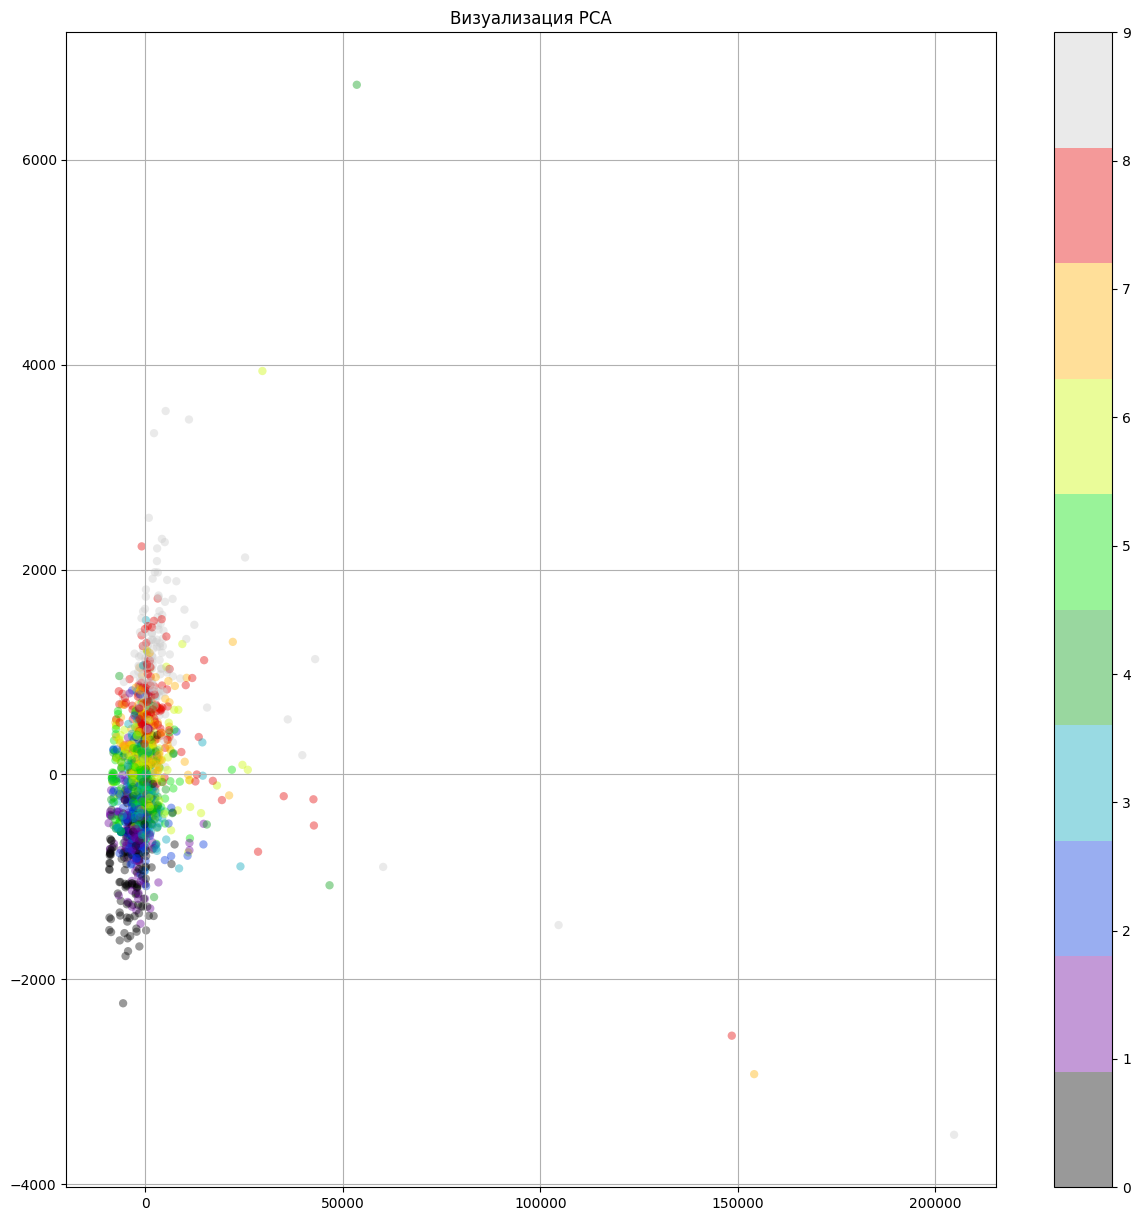

In [18]:
visualize_data(pca_3, "PCA")

Разброс данных стал чуть меньше относительно **PCA** с двумя компонентами, однако данные все равно перемешаны. Время работы не изменилось.

In [19]:
%%time

tsne = TSNE(random_state=0, n_components=3)
tsne_3 = tsne.fit_transform(X)

CPU times: total: 1min 15s
Wall time: 4.81 s


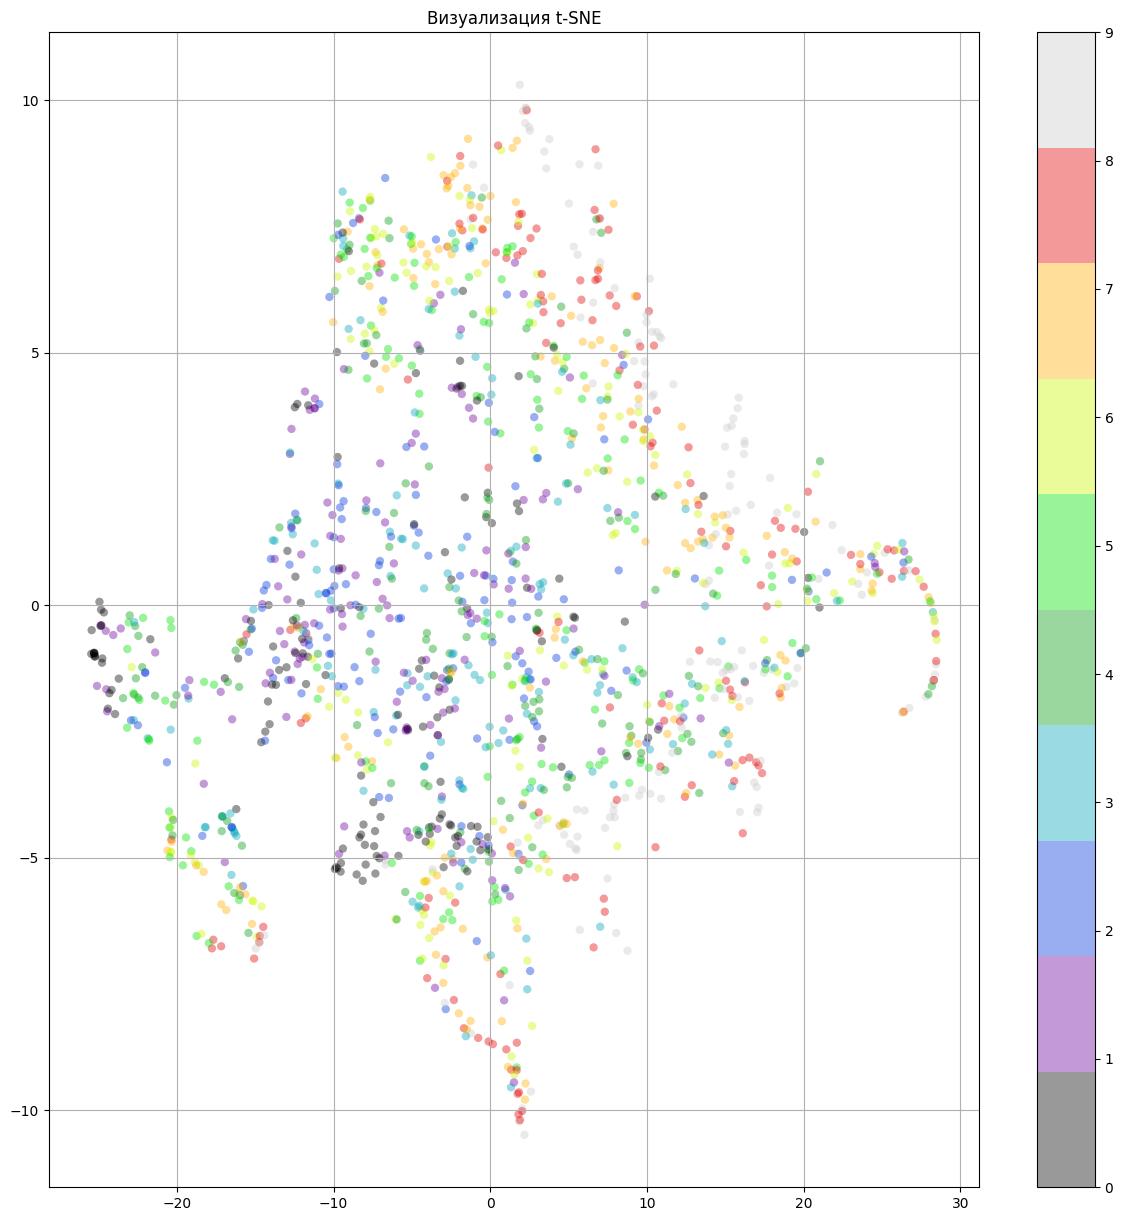

In [20]:
visualize_data(tsne_3, "t-SNE")

Разброс данных стал чуть меньше относительно **t-SNE** с двумя компонентами Время работы увеличилось.

### Качество кластеризации

Подгружаем необходимые библиотеки и вычисляем дисперсию:

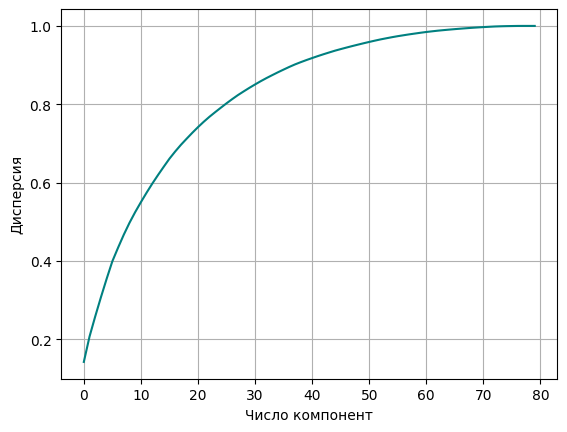

In [21]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA().fit(df_scaled) 
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='teal')
plt.xlabel('Число компонент') 
plt.ylabel('Дисперсия')
plt.grid(True)

In [22]:
pca = PCA(0.99).fit(df_scaled)
pca.n_components_ 

65

In [23]:
pca = PCA(0.80).fit(df_scaled)
pca.n_components_ 

26

In [24]:
pca = PCA(0.50).fit(df_scaled)
pca.n_components_ 

10

In [25]:
pca = PCA(0.25).fit(df_scaled)
pca.n_components_ 

3

In [26]:
pca = PCA(0.20).fit(df_scaled)
pca.n_components_ 

2

Можно сделать следующий выводы:
- Для сохранения **99%** исходной информации необходимо **65** компонент;
- Для сохранения **80%** исходной информации необходимо **26** компонент;
- Для сохранения **50%** исходной информации необходимо **10** компонент;
- При экстремальном снижении размерности до **3** сохранится лишь **25%** исходной информации;
- При снижении размерность до **2** сохранится **20%**.

## Реализация алгоритма K-means

Самостоятельно реализуем алгоритм K-means:

In [27]:
import numpy.typing as npt
from sklearn.base import BaseEstimator, ClusterMixin
from numpy.random import RandomState


class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_components=65, tol=1e-4):
        self.n_components = n_components
        self.tol = tol
        self.random_state = RandomState(42)
    
    
    def calculate_initial_clusters(self, X, components_number):
        return X[self.random_state.choice(len(X), size=components_number, replace=False), :]
    
        
    def calculate_clusters(self, X):
        dist_to_centers = np.linalg.norm(X[..., None] - self.cluster_centers.T, axis=1)
        return np.argmin(dist_to_centers, axis=1)
    
    
    def calculate_centers(self, X):
        # Находим новые центроиды как средние объекты в текущих кластерах
        new_centers = np.empty((self.n_components, self.features_number))
        for label in np.unique(self.labels_):
            new_centers[label] = np.mean(X[self.labels_ == label], axis=0)
            
        return new_centers
        
    def is_centered_cluster(self, center_position):
        return center_position <= self.tol
        
        
    def fit(self, X, y=None):
        self.features_number = X.shape[1]

        self.cluster_centers = self.calculate_initial_clusters(X, self.n_components)

        center_position = np.inf
        while not self.is_centered_cluster(center_position):
            self.labels_ = self.calculate_clusters(X)
            new_centers = self.calculate_centers(X)
            center_position = np.max(np.linalg.norm(self.cluster_centers - new_centers, axis=1))
            self.cluster_centers = new_centers

        return self

    
    def predict(self, X):
        return self.calculate_clusters(X)

## Обучение моделей кластеризации

Обучение моделей будем произовдить на датасетах со сниженной размерностью. Ранее выяснили:
- Для сохранения **99%** исходной информации необходимо **65** компонент;
- Для сохранения **80%** исходной информации необходимо **26** компонент;
- Для сохранения **50%** исходной информации необходимо **10** компонент.

In [28]:
component_number = [10, 26, 65]
X_reduced = [X.to_numpy(dtype=np.float64)]
for reduced_dims in component_number:
    pca = PCA(n_components=reduced_dims)
    X_transformed = pca.fit_transform(X)
    X_reduced.append(X_transformed)

При обучении моделей воспользуемся подбором гиперпараметров. Подобранные значения гиперпараметров будем сохранять в CSV-файл *temp.csv*. Для оценки воспользуемся метриками ARI, AMI, FMI.

In [29]:
import pathlib

HYPERPARAM_PATH = pathlib.Path("temp.csv")

Напишем функцию обучения моделей с сохранением результатов в файл.

In [30]:
import pathlib
import itertools
import time
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score


def generate_parameters_combination(parameters):
    return [
        dict(params) for params in
        itertools.product(
            *([(name, v) for v in vs] for (name, vs) in parameters.items())
        )
    ]


def generate_result(estimator, size, best_ari, best_ami, best_fmi):
    best_prediction_time = np.mean([best_ari[1], best_ami[1], best_fmi[1]])
    return {
        "Cluster name": estimator.__class__.__name__,
        "Dimension": size,
        "Learning time, sec": best_prediction_time,
        "ARI": best_ari[0],
        "AMI": best_ami[0],
        "FMI": best_fmi[0],
    }


def print_result(size, ari, ami, fmi):
        print(
        f"Подбор гиперпараметров для размерности {size}:",
        f"ARI: {ari[2]}",
        f"AMI: {ami[2]}",
        f"FMI: {fmi[2]}",
        "",
        sep="\n",
    )
        
        
def is_better_result(best_result, cur_result):
    return best_result == None or cur_result > best_result[0]


def train(estimator, parameters = None, log=True):
    parameters = parameters if parameters is not None else {}
    param_combs = generate_parameters_combination(parameters)
    
    results = []
    for X in X_reduced:
        best_ari = None
        best_ami = None
        best_fmi = None

        size = X.shape[1]
        for params in param_combs:
            cur_estimator = clone(estimator).set_params(**params)

            start_t = time.perf_counter()
            pred = cur_estimator.fit_predict(X)
            fit_predict_time = (time.perf_counter() - start_t)

            ari = adjusted_rand_score(y, pred)
            if is_better_result(best_ari, ari):
                best_ari = ari, fit_predict_time, params

            ami = adjusted_mutual_info_score(y, pred)
            if is_better_result(best_ami, ami):
                best_ami = ami, fit_predict_time, params

            fmi = fowlkes_mallows_score(y, pred)
            if is_better_result(best_fmi, fmi):
                best_fmi = fmi, fit_predict_time, params

        if log:
            print_result(size, best_ari, best_ami, best_fmi)
            
        results.append(generate_result(estimator, size, best_ari, best_ami, best_fmi))

    pd.DataFrame(results).to_csv(HYPERPARAM_PATH, mode="a", header=not HYPERPARAM_PATH.exists())

Обучим собственную реализацию алгоритма **KMeans**:

In [31]:
%%time

model = MyKMeans(n_components=10)
train(model, log=False)

CPU times: total: 891 ms
Wall time: 889 ms


Обучим библиотечную реализацию алгоритма **KMeans**:

In [32]:
%%time
from sklearn.cluster import KMeans

model = KMeans(n_clusters=10, n_init="auto", random_state=0)
hyper_parameters = {
        "algorithm": ["lloyd", "elkan"],
        "max_iter": [300, 400, 500]
    }

train(model, hyper_parameters)

Подбор гиперпараметров для размерности 80:
ARI: {'algorithm': 'lloyd', 'max_iter': 300}
AMI: {'algorithm': 'lloyd', 'max_iter': 300}
FMI: {'algorithm': 'lloyd', 'max_iter': 300}

Подбор гиперпараметров для размерности 10:
ARI: {'algorithm': 'lloyd', 'max_iter': 300}
AMI: {'algorithm': 'lloyd', 'max_iter': 300}
FMI: {'algorithm': 'lloyd', 'max_iter': 300}

Подбор гиперпараметров для размерности 26:
ARI: {'algorithm': 'lloyd', 'max_iter': 300}
AMI: {'algorithm': 'lloyd', 'max_iter': 300}
FMI: {'algorithm': 'lloyd', 'max_iter': 300}

Подбор гиперпараметров для размерности 65:
ARI: {'algorithm': 'lloyd', 'max_iter': 300}
AMI: {'algorithm': 'lloyd', 'max_iter': 300}
FMI: {'algorithm': 'lloyd', 'max_iter': 300}

CPU times: total: 3.72 s
Wall time: 281 ms


Обучим библиотечную реализацию алгоритма **DBSCAN**:

In [33]:
%%time
from sklearn.cluster import DBSCAN

model = DBSCAN(n_jobs=-1)
hyper_parameters ={
    "eps": [500, 1000, 1500, 2000],
    "min_samples": [10, 50, 100, 200],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [30, 50, 70]
}

train(model, hyper_parameters)

Подбор гиперпараметров для размерности 80:
ARI: {'eps': 1000, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}
AMI: {'eps': 1000, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}
FMI: {'eps': 500, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}

Подбор гиперпараметров для размерности 10:
ARI: {'eps': 1000, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}
AMI: {'eps': 1000, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}
FMI: {'eps': 500, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}

Подбор гиперпараметров для размерности 26:
ARI: {'eps': 1000, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}
AMI: {'eps': 1000, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}
FMI: {'eps': 500, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}

Подбор гиперпараметров для размерности 65:
ARI: {'eps': 1000, 'min_samples': 50, 'algorithm': 'auto', 'leaf_size': 30}
AMI: {'eps': 1000, 'min_samples': 50, 'algorithm': 'auto', 'leaf_siz

Считаем сохранённые результаты и построим графики:

<Axes: title={'center': 'Learning time, sec'}, xlabel='Dimension', ylabel='Learning time, sec'>

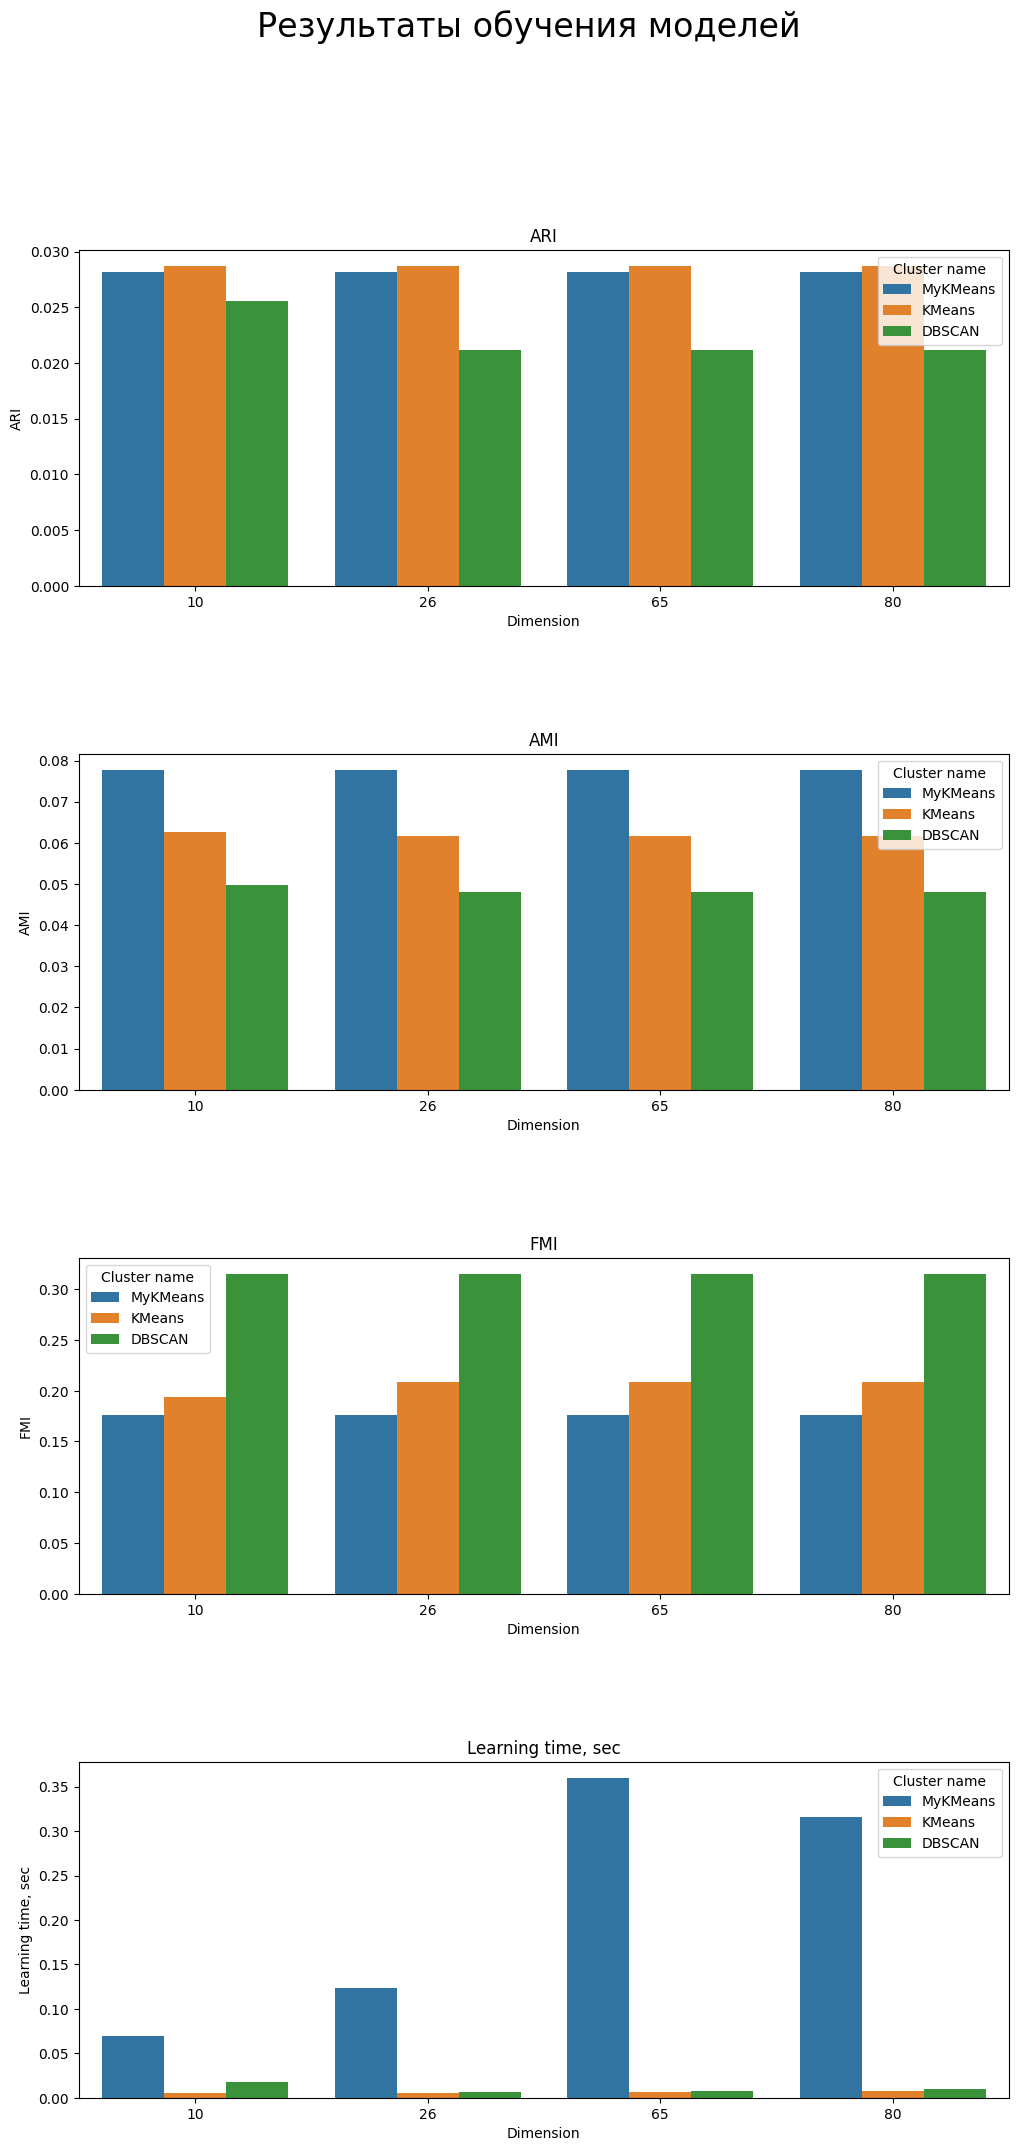

In [34]:
results = pd.read_csv(HYPERPARAM_PATH)

plt.figure(figsize=(12, 24))

plt.suptitle("Результаты обучения моделей", fontsize = 24)
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

plt.subplot(4, 1, 1)
plt.title("ARI")
sns.barplot(results, x="Dimension", y="ARI", hue="Cluster name")

plt.subplot(4, 1, 2)
plt.title("AMI")
sns.barplot(results, x="Dimension", y="AMI", hue="Cluster name")

plt.subplot(4, 1, 3)
plt.title("FMI")
sns.barplot(results, x="Dimension", y="FMI", hue="Cluster name")

plt.subplot(4, 1, 4)
plt.title("Learning time, sec")
sns.barplot(results, x="Dimension", y="Learning time, sec", hue="Cluster name")

**Выводы**:
- **ARI**:
    - Реализации **KMeans** имеют **большее** значения ARI, чем **DBSCAN**;
    - **Собственная** реализация KMeans имеет **меньшее** значение ARI, чем **библиотечная** реализация;
- **AMI**: 
    - Реализации **KMeans** имеют **большее** значения ARI, чем **DBSCAN**;
    - **Собственная** реализация KMeans имеет **большее** значение ARI, чем **библиотечная** реализация;
- **FMI**:
    - Реализации **KMeans** имеют **меньшие** значения FMI, чем **DBSCAN**;
    - **Собственная** реализация KMeans имеет **большее** значение ARI, чем **библиотечная** реализация;
- **Время обучения**:
    - **Собственная реализация** алгоритма KMeans обучается **заметно дольше**, чем библиотечные реализации;
    - Библиотечная реализация **KMeans** обучается быстрее, чем библиотечная реализация **DBSCAN**;